In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
# Libraries
print("\tImporting libraries...\n")
import sys; sys.path.append("..")
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

# ml libraries
from sklearn.metrics import r2_score

# dl libraries
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
torch.set_float32_matmul_precision('high')

# ext. libraries
import src.utils as utils
import src.models as models
from src.visuals import CustomVisualizer
print("\tImport complete!\n")

utils.set_plt_style()
device = utils.get_device_info()
seed = utils.set_all_seeds()

NUM_WORKERS = 23
DATASET_NAME = "mimic-iv-ecg"
DATASET_DIR = os.path.join("..", "data", DATASET_NAME)
OUTPUT_DIR = os.path.join("..", "out", DATASET_NAME)
SCORE_METRIC = 'test_r2'
score_metric = r2_score

	Importing libraries...


=== Environment Information ===
Python version: 3.12.2
PyTorch version: 2.6.0
NumPy version: 1.26.4
Platform: macOS-15.4.1-arm64-arm-64bit



Seed set to 42


	Import complete!


=== Device Information ===
CUDA available: False
Using device: cpu


=== Setting Random Seeds ===
Seed value: 42
Setting torch CPU seed...
Setting torch CUDA seed...
Setting numpy seed...
Configuring CUDNN...
Configuring PL...



In [ ]:
X_train, y_train, X_test, y_test = torch.load(f"{DATASET_DIR}/dataset.pt")

In [4]:
# Create an empty dictionary
model_results = {'model_name': [], 'test_loss': [], SCORE_METRIC: []}
max_epochs = 1000

def train_evaluate_cnn(current_X_train, y_train, current_X_test, y_test, model_name, config_dim=0):  
    cnn = models.CustomCNN(
        input_channels=12,
        num_classes=None,
        conv_channels=[8, 16, 32],
        kernel_sizes=[3, 3, 3],
        pool_sizes=[2, 2],
    )

    litcnn = models.LitCNN(
        model=cnn,
        loss_func=nn.MSELoss(),
        score_func=score_metric,
        metric_name=SCORE_METRIC.split('_')[1],
        is_classifier=False
    )

    train_set = TensorDataset(current_X_train, y_train)
    test_set = TensorDataset(current_X_test, y_test)
    train_set, val_set = utils.train_val_split(train_set)
    train_loader = DataLoader(train_set, batch_size=10, shuffle=True, num_workers=NUM_WORKERS // 7, persistent_workers=True)
    val_loader = DataLoader(val_set, batch_size=len(val_set), shuffle=False)
    test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)

    trainer = pl.Trainer(max_epochs=max_epochs, default_root_dir=OUTPUT_DIR, callbacks=[models.LitProgressBar()])
    trainer.fit(litcnn, train_loader, val_loader)
    result = trainer.test(litcnn, test_loader)

    # Add current model results to the lists
    model_results['model_name'].append(model_name)
    model_results['test_loss'].append(result[0]['test_loss'])
    model_results[SCORE_METRIC].append(result[0][SCORE_METRIC])

    cvi = CustomVisualizer(litcnn, model_name)
    _, axes = cvi.create_subplot_grid(1, 2, figsize=(10, 4))
    cvi.plot_epoch_loss(max_epochs, ax=axes[0, 0])
    cvi.plot_actual_vs_predicted(test_loader, ax=axes[0, 1])
    plt.show()
    
    torch.cuda.empty_cache()
    return litcnn

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | model     | CustomCNN | 6.5 K  | train
1 | loss_func | MSELoss   | 0      | train
------------------------------------------------
6.5 K     Trainable params
0         Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/ml/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.
/opt/anaconda3/envs/ml/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     47.8935432434082      │
│          test_r2          │    -155.28912353515625    │
└───────────────────────────┴───────────────────────────┘

ValueError: Input contains NaN.

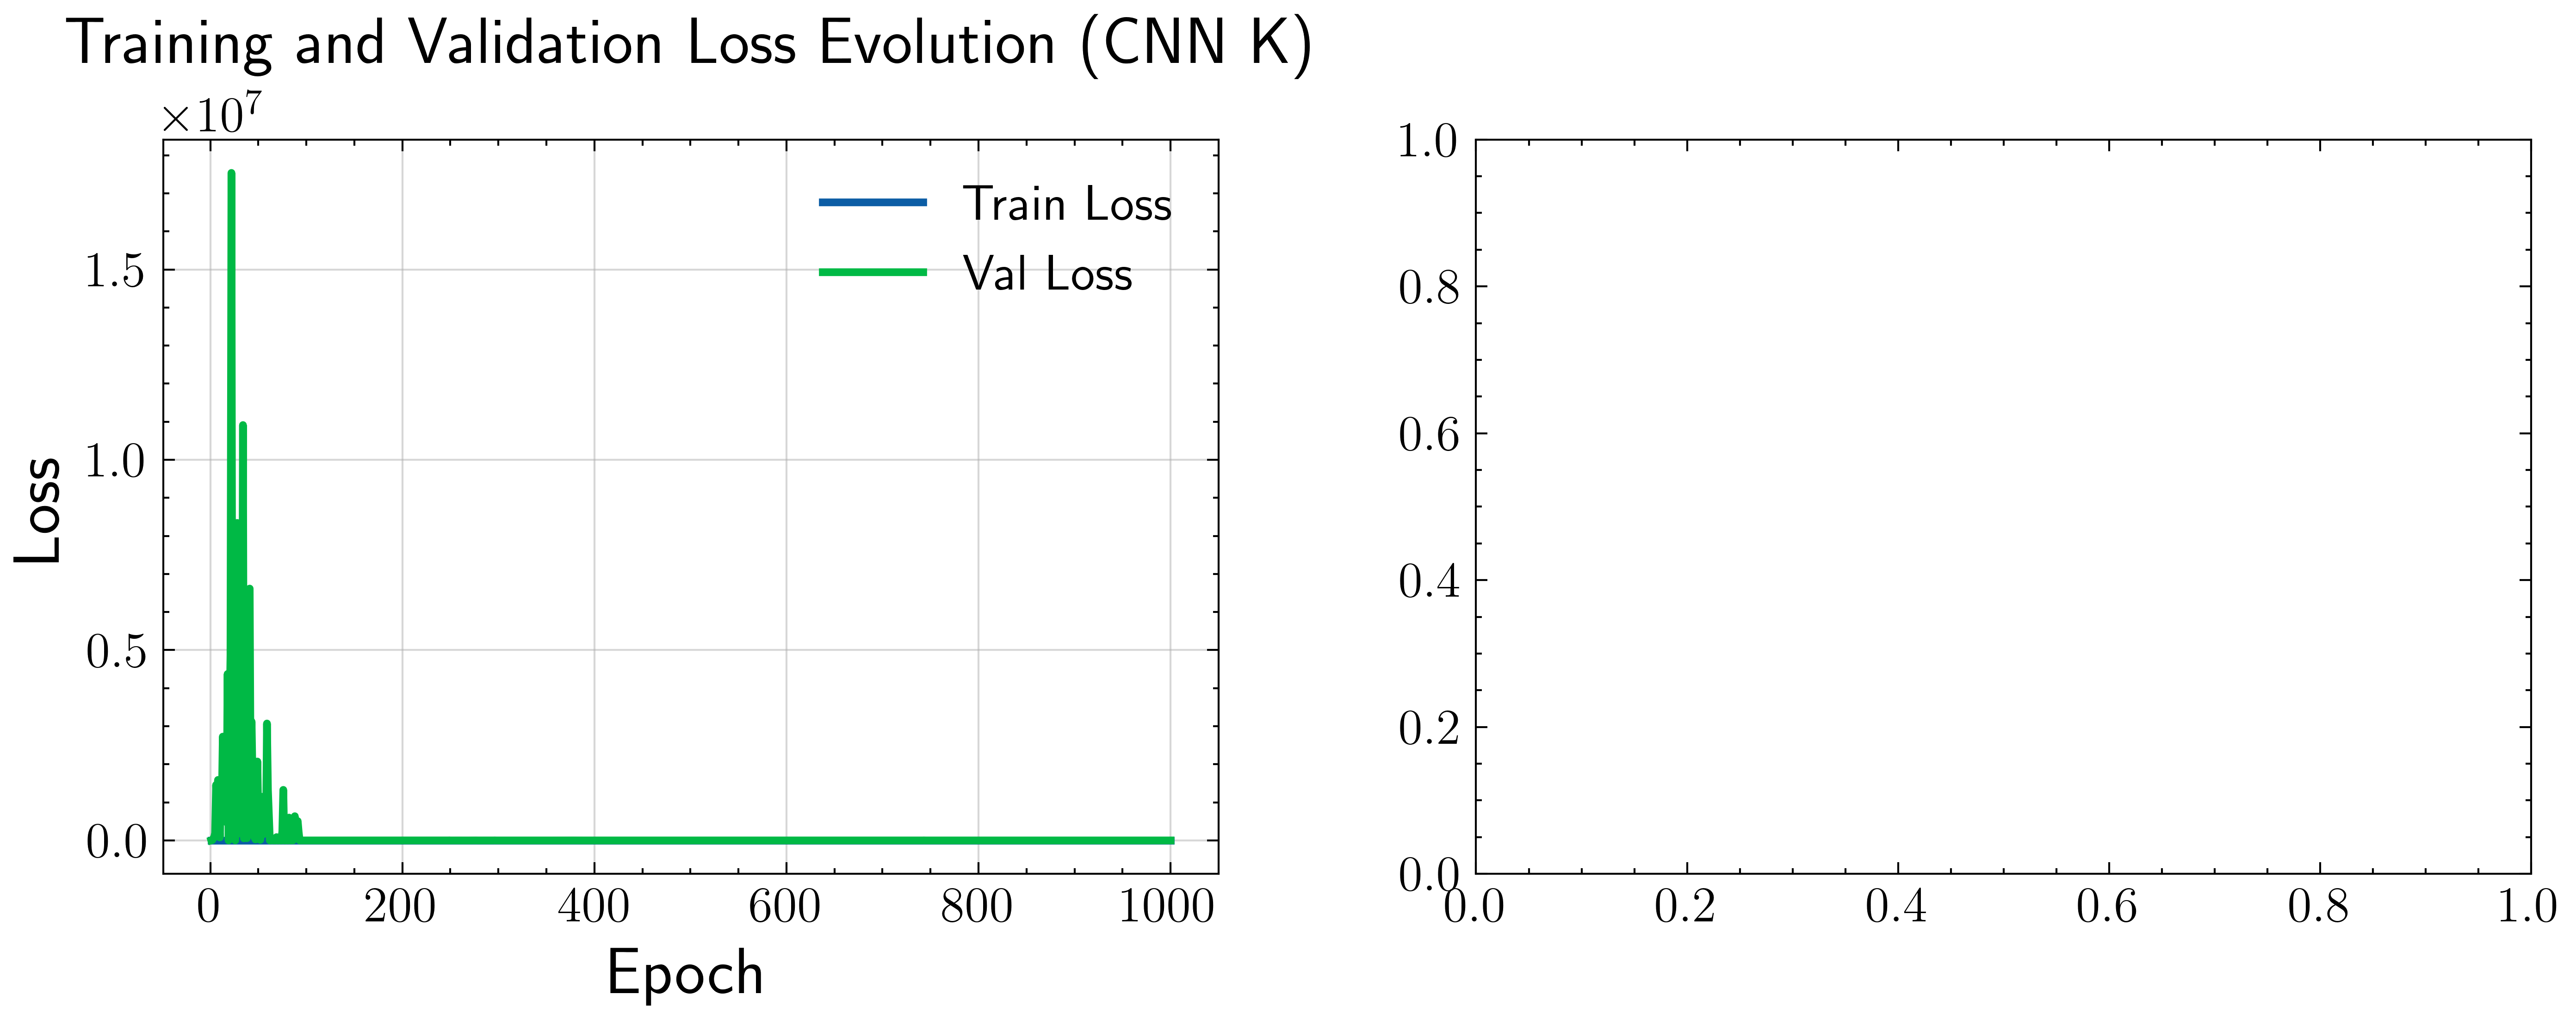

In [5]:
y_k_train, y_k_test = y_train[:,0], y_test[:,0]
y_ca_train, y_ca_test = y_train[:,1], y_test[:,1]

train_evaluate_cnn(X_train, y_k_train, X_test, y_k_test, "(CNN K)")